In [182]:
using DataFrames
using CSV
using StatsPlots
using Chain
using GLM
using Survival

In [14]:
df = CSV.File("data.csv") |> DataFrame
df.sex = string.(df.sex)
first(df, 5)

Row,id,treatment,sex,time,volume
,Int64,String15,String1,Int64,Float64
1,861540,vehicle,m,1,233.28
2,861540,vehicle,m,4,461.709
3,861540,vehicle,m,8,653.0
4,861540,vehicle,m,11,1091.66
5,861540,vehicle,m,15,1690.13


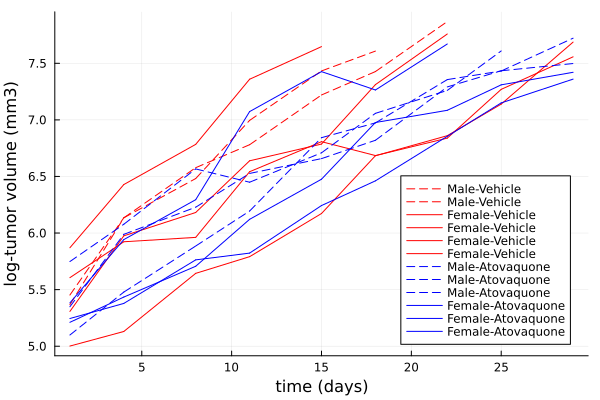

In [114]:
plotdf = @chain df begin
    # transform(:treatment .=> (s -> s == "vehicle" ? "red" : "blue") => :color)
    transform(:treatment => (s -> s .|> s -> startswith(s, "v") ? "red" : "blue") => :color)
    transform(:sex => (s -> s .|> s -> startswith(s, "m") ? :dash : :solid) => :linestyle)
    transform([:treatment, :sex] => ((x,y) -> zip(x,y) .|> x -> begin
        tt = ""
        tt *= startswith(x[2], "m") ? "Male-" : "Female-" 
        tt *= startswith(x[1], "v") ? "Vehicle" : "Atovaquone"
        tt
    end) => :group_name)
end

p = plot(
    ylab = "log-tumor volume (mm3)",
    xlab = "time (days)",
    legend = :bottomright,
    title = "Tumor volume growth over time"
)
for label in unique(plotdf.group_name)
    df_lab = filter(:group_name => ==(label), plotdf)
    for id in unique(df_lab.id)
        df_ind = filter(:id => ==(id), df_lab)
        @df df_ind plot!(p, :time, log.(:volume),
            # marker_z = :id,
            linecolor = :color, 
            linestyle = :linestyle,
            label = label,
            legend = :bottomright
        )
        label = ""
    end
end

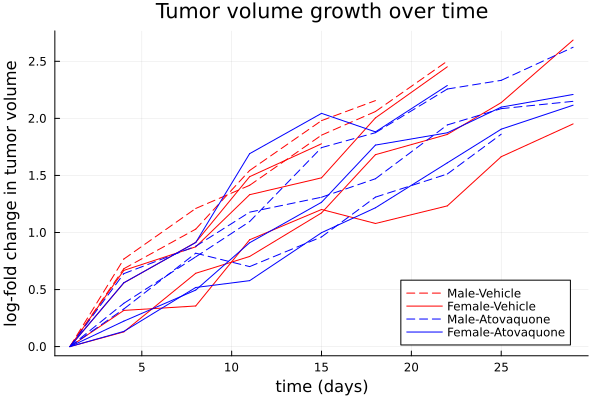

In [136]:
plotdf = @chain df begin
    # transform(:treatment .=> (s -> s == "vehicle" ? "red" : "blue") => :color)
    transform(:treatment => (s -> s .|> s -> startswith(s, "v") ? "red" : "blue") => :color)
    transform(:sex => (s -> s .|> s -> startswith(s, "m") ? :dash : :solid) => :linestyle)
    transform([:treatment, :sex] => ((x,y) -> zip(x,y) .|> x -> begin
        tt = ""
        tt *= startswith(x[2], "m") ? "Male-" : "Female-" 
        tt *= startswith(x[1], "v") ? "Vehicle" : "Atovaquone"
        tt
    end) => :group_name)
    groupby(:id)
    combine(_) do sdf
        base_vol = filter(:time => ==(1), sdf).volume[1]
        sdf.change = sdf.volume / base_vol
        sdf
    end
end

p = plot(
    ylab = "log-fold change in tumor volume",
    xlab = "time (days)",
    legend = :bottomright,
    title = "Tumor volume growth over time"
)
for label in unique(plotdf.group_name)
    df_lab = filter(:group_name => ==(label), plotdf)
    for id in unique(df_lab.id)
        df_ind = filter(:id => ==(id), df_lab)
        @df df_ind plot!(p, :time, log.(:change),
            # marker_z = :id,
            linecolor = :color, 
            linestyle = :linestyle,
            label = label,
            legend = :bottomright
        )
        label = ""
    end
end

p

In [174]:
@chain df begin
    groupby(:id)
    combine(_) do sdf
        base_vol = filter(:time => ==(1), sdf).volume[1]
        sdf.change = log.(sdf.volume) .- log.(base_vol)
        sdf
    end
    transform(:treatment => (x -> x .|> x -> startswith(x, "v") ? "Vehicle" : "Atovaquone") => :treatment)
    transform(:sex => (x -> x .|> x -> startswith(x, "m") ? "Male" : "Female") => :sex)

    filter(:time => ==(15), _)
    lm(@formula(change ~ treatment + sex), _)
    # @df _ scatter(:treatment, :change, 
    # group = :sex,
    # xlim = [0.0, 2.0]
    # )
    # @df _ scatter(:sex, :change, 
    #     group = :treatment,
    #     xlim = [0.0, 2.0]
    # )
end

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

change ~ 1 + treatment + sex

Coefficients:
──────────────────────────────────────────────────────────────────────────────
                       Coef.  Std. Error     t  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────────
(Intercept)         1.29273     0.199584  6.48    0.0001   0.841241   1.74422
treatment: Vehicle  0.22164     0.231565  0.96    0.3635  -0.302197   0.745477
sex: Male           0.187983    0.23485   0.80    0.4441  -0.343284   0.719251
──────────────────────────────────────────────────────────────────────────────

In [176]:
(a = 1, b = 2)

(a = 1, b = 2)

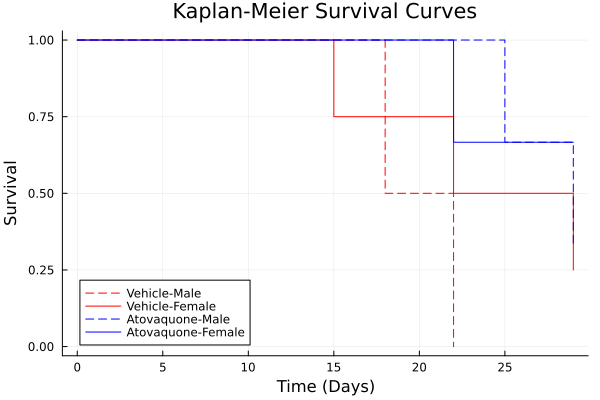

In [250]:
p = plot(
    legend = :bottomleft,
    ylab = "Survival",
    xlab = "Time (Days)",
    title = "Kaplan-Meier Survival Curves"
)
@chain df begin
    transform(:treatment => (s -> s .|> s -> startswith(s, "v") ? :red : :blue) => :color)
    transform(:sex => (s -> s .|> s -> startswith(s, "m") ? :dash : :solid) => :linestyle)
    transform(:treatment => (x -> x .|> x -> startswith(x, "v") ? "Vehicle" : "Atovaquone") => :treatment)
    transform(:sex => (x -> x .|> x -> startswith(x, "m") ? "Male" : "Female") => :sex)
    groupby(:id)
    combine(_) do sdf
        (
            id = sdf.id[1],
            treatment = sdf.treatment[1],
            sex = sdf.sex[1],
            linestyle = sdf.linestyle[1],
            color = sdf.color[1],
            group = sdf.treatment[1] * "-" * sdf.sex[1],
            time = EventTime(maximum(sdf.time), maximum(sdf.volume) >= 2000),
        )
    end

    groupby([:treatment, :sex])
    combine(_) do sdf
        model = fit(KaplanMeier, sdf.time)
        plot!(p, vcat(0.0, model.events.time), vcat(1.0, model.survival), 
            line = (:steppost, sdf.linestyle[1], sdf.color[1]) ,
            label = sdf.group[1]
        )
    end
end
p

In [253]:
@chain df begin
    transform(:treatment => (x -> x .|> x -> startswith(x, "v") ? "Vehicle" : "Atovaquone") => :treatment)
    transform(:sex => (x -> x .|> x -> startswith(x, "m") ? "Male" : "Female") => :sex)
    groupby(:id)
    combine(_) do sdf
        (
            id = sdf.id[1],
            treatment = sdf.treatment[1],
            sex = sdf.sex[1],
            group = sdf.treatment[1] * "-" * sdf.sex[1],
            time = EventTime(maximum(sdf.time), maximum(sdf.volume) >= 2000),
        )
    end

    coxph(@formula(time ~ treatment + sex), _)
end

StatsModels.TableRegressionModel{CoxModel{Float64}, Matrix{Float64}}

time ~ treatment + sex

Coefficients:
──────────────────────────────────────────────────────────
                    Estimate  Std.Error  z value  Pr(>|z|)
──────────────────────────────────────────────────────────
treatment: Vehicle   1.50421   0.847908  1.77402    0.0761
sex: Male            1.04553   0.820879  1.27367    0.2028
──────────────────────────────────────────────────────────